In [ ]:
#@title Imports
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import RMSprop
from scipy import stats
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import os
import sys
import time
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from google.colab import files
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
root_logdir = os.path.join(os.curdir,'my_logs')
from keras import regularizers
%load_ext tensorboard
print(f"Tensorflow version: {tf.__version__}, Keras version: {keras.__version__}")

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

Tensorflow version: 2.12.0, Keras version: 2.12.0


In [ ]:
#@title Hardware Detection

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines (works on CPU too)
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

# To use the selected distribution strategy:
# with strategy.scope:
#    # --- define your (Keras) model here ---
#
# For distributed computing, the batch size and learning rate need to be adjusted:
# global_batch_size = BATCH_SIZE * strategy.num_replicas_in_sync # num replcas is 8 on a single TPU or N when runing on N GPUs.
# learning_rate = LEARNING_RATE * strategy.num_replicas_in_sync

Number of accelerators:  1


In [ ]:
#@title Predictors

class Network():
  '''
  Creates a Linear Newral Network using keras
  ------------------------------------------------------------------------------
  Variables:
    loss             : The loss function used in training, set to 'mean_square error'.
    optimizer        : The optimizer to run backpropagation with we choose SGD.
    digit            : The chosen digit of the MNIST
    prediction       : A list of all the networks outputs
    final_loss       : A list with the systems achieved loss at the end of training.
    X_train, y_train : The training set
    X_test,vy_test   : The validation set

  Methods:
    dataset_creation() : Calls the MNIST set, creates a 85/15 train test split
                       and chooses a specific digit.

    network_creation() : Creates a sequential model with 1 hidden layer that
                       consists of flattening the input the passing it to a
                       dense layer. Each layer has an L2 weight penaldy. The
                       network is compiled and trained with the class variables.

    run()              : A one call running of all the class methods to create the
                       specified dataset, traiin the network, validate and pass
                       the trained parameters as class instance variables.
  ------------------------------------------------------------------------------
  '''

  def __init__(self, digit):
    self.loss = "mean_squared_error"
    self.opt = keras.optimizers.legacy.SGD()
    self.digit = digit
    self.final_loss = None
    self.prediction = []
    self.X_test, self.y_test = 0, 0
    self.X_train, self.y_train = 0,0

  def dataset_creation(self):
    '''Loads the MNIST Dataest'''
    (X, y),(self.X_test, self.y_test) = mnist.load_data()
    train_filter = np.where((y == self.digit)) # | (y == 9))
    test_filter = np.where((self.y_test == self.digit)) # | (self.y_test == 9))
    self.X_train, self.y_train = X[train_filter]/255.0, y[train_filter]
    self.X_test, self.y_test = X[test_filter]/255.0, y[test_filter]
      #print(f"shapes = {self.X_train.shape}, {self.X_test.shape}")

  def network_creation(self,epochs,l2):
    '''Creates and runs an MLP for the MNIST dataset'''
    self.model = keras.models.Sequential()
    self.model.add(keras.layers.Flatten(input_shape=[28,28]))
    self.model.add(keras.layers.Dense(units=28*28,activation='linear',kernel_regularizer=regularizers.L2(l2=l2)))
    self.model.add(keras.layers.Dense(units=1,activation='linear',kernel_regularizer=regularizers.L2(l2=l2)))
    self.model_summary = self.model.summary()
    self.model.compile(loss=self.loss, optimizer=self.opt, metrics=[self.loss])
    history = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data =(self.X_test, self.y_test),verbose=1)
    self.prediction.append(self.model.predict(self.X_train)) #FLAG!
    self.final_loss = history.history

  def run(self, epochs,l2):
    ''' Runs the instaces to train and test the network'''
    self.dataset_creation()
    self.network_creation(epochs, l2)
    #print(f"predictions: {self.prediction[:][0:5]}, labels:{self.y_train[0:5]}, P = {np.shape(self.X_train)}")
    return self.prediction


class Solution(Network):
  ''' Implements the networks predictor f(x) using the result from [2012.04030v].
    ----------------------------------------------------------------------------
    Variables:
      Inherits from -> Network()
      P       : The amount of examples from which to consider x.
      X_stack : The NxP matrix X with all the training examples

    Methods:
      Stacker : Creates the X matrix by stacking up different examples and
                computes A = (X^T X)^{-1} X Y. The inverse is done by using the
                Penrose inverse for matrix X^T X

      predictor1 : Implements the predictor by computing xA = f(x)
    ----------------------------------------------------------------------------
  '''
  def __init__(self, digit):
    super().__init__(digit)
    self.digit = digit
    self.dataset_creation()
    self.P = self.X_train.shape[0]
    self.X_stack = 0

  def stacker(self):
    '''Column stacks X es into a big matrix'''
    X,Y = self.X_train, self.y_train
    X_stack = np.column_stack((X[0].flatten(),X[1].flatten()))
    for i in range(2,int(self.P/2)+1):
      dummy = np.column_stack((X[i+1].flatten(),X[i+2].flatten()))
      X_stack = np.column_stack((X_stack,dummy))
    self.X_stack = X_stack

  def predictor(self,s,T):
      X,Y = self.X_train, self.y_train
      P = 500
      L=2
      a=P/784
      yp = Y[0:P]
      Y = Y[0:P][np.newaxis].T
      val = self.X_train[np.random.randint(0,500)].flatten()
      #creating N*P matrix XNP containing column of elements of the training set of cardinality P (also N = 28*28)
      XNP = np.column_stack(( self.X_train[0].flatten(),self.X_train[1].flatten() ))
      for i in range(2,int(P/2)+1):
        dummy = np.column_stack((self.X_train[i+1].flatten(),self.X_train[i+2].flatten()))
        XNP = np.column_stack((XNP,dummy))
      #computing average of f

      #for zero T
      XTX = np.matmul(XNP.T,XNP)
      K =(s**2)/(784)*(XTX)
      Kinv=np.linalg.pinv(K)
      d=np.matmul(Kinv,Y)
      k=(s**2)/(784)*np.matmul(val,XNP)
      fmed=np.matmul(k,d)

      #for finite T
      r=(1/P)*np.matmul(yp,np.matmul(Kinv,Y))
      f = lambda x: 1-x/(s**2)-a+a*r/(x**L)
      u=fsolve(f, [-10000000, 10000000])[0]
      KTinv=np.linalg.pinv(u**(L)*K+T*np.identity(P))
      fmedT=(u**L)*np.matmul(k,np.matmul(KTinv,Y))

      return [fmed,fmedT]

  def predictor1(self):
    ''' Implements the full predictor and returns the value f(x)'''
    X,Y = self.X_train, self.y_train
    yp, Y = Y[0:self.P], Y[0:self.P][np.newaxis].T
    val = self.X_train[np.random.randint(0,self.P-1)].flatten()
    #computing predictor of f
    XXT = np.matmul(self.X_stack,self.X_stack.T)
    U = np.linalg.pinv(XXT)
    b = np.matmul(U,np.matmul(self.X_stack,Y))
    return np.matmul(val,b)

In [ ]:
def T_extractor(digit,epochs,max_temp):
  '''
  Creates the T dependance plots for the MSE and LOSS
  ------------------------------------------------------------------------------
  Args:
    digit    : The choice MNIST subset (one of the digits)
    epochs   : The number of epochs for which to run the NN
    max_temp : The maximum temperature for which to test

  Outputs:
    A pd.DataFrame containing all the results as a 50x2 matrix for 50
    (50 steps till max temp and 3 variables being: MSE, LOSS)

  IMORTANT: These are for the train set, in order to change them one has to
  modify the '#FLAG!' part of the code in the network as:
  self.prediction.append(self.model.predict(self.X_train)) ->
  self.prediction.append(self.model.predict(self.X_test))
  ------------------------------------------------------------------------------

  '''
  net = Network(digit)
  global tlist
  tlist = np.linspace(0,max_temp,50)
  mse_list, loss_list = [], []
  for temp in tlist:
    ytest = net.run(epochs,temp)
    mse = net.final_loss['mean_squared_error'][0]
    loss = net.final_loss['loss'][0]
    mse_list.append(mse)
    loss_list.append(loss)
  df = pd.DataFrame(data={'Temperature':tlist, 'MSE':mse_list, 'loss':loss_list})
  return df

In [ ]:
my_list = T_extractor(3,5,50)
plot=sns.lineplot(data=my_list, x='Temperature', y='MSE')

[ 0.5 50.5]


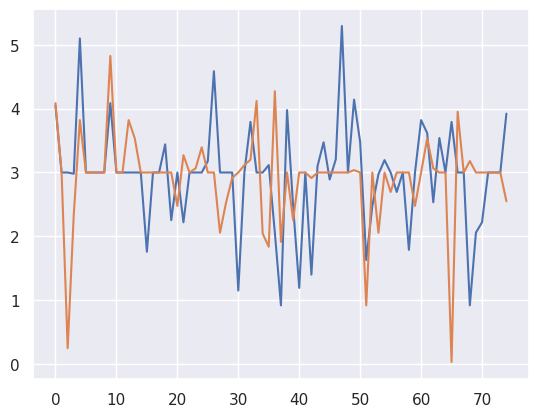

In [ ]:
run=Solution(3)
booba=[]
s=np.arange(0.5, 100, 50)
print(s)
for element in s:
  booba=[]
  for i in range(30):
    booba.append(run.predictor(element,0)[1])
  plt.plot(booba)

In [ ]:
#@title nn test
def NN_test(kind, digit, epochs, temperature):
  '''
  Call the Network class and runs a LNN
  ------------------------------------------------------------------------------
  Args:
    kind        : 0 implements the solution anything else implements NN
    digit       : The specified digit of the MNIST
    epochs      : The number of epochs for the NN to run
    temperature : The systems L2 regularizer term

  Outputs:
    Plot of the predictions in a filename of the form:
      "kind,digit,epochs,temperature,(mean, standard_deviation).png"
  ------------------------------------------------------------------------------
  '''
  lista = []

  if kind == 0:
    samples = 900
    iterator = samples
    net = Solution(digit)
    net.stacker()
    lista = [net.predictor1() for _ in range(samples)]
    df = pd.DataFrame(lista)
    mse =0
    for i in range(samples):
      mse += 1/net.P * (lista[i][:][0])**2

  elif kind == 1:
    net = Network(digit)
    iterator = epochs
    ytest = net.run(epochs,temperature)
    mse = net.final_loss['mean_squared_error'][0]
    for i in range(net.X_test.shape[0]):
        lista.append(ytest[0][i][0])
    df = pd.DataFrame(lista)

  df.rename(columns={0:f'f({net.digit})'}, inplace=True)
  plot = sns.histplot(df, kde=True,
              bins=20, color = 'darkblue',
              stat = 'density')

  def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x-net.digit, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

  mean, dev = df[f'f({net.digit})'].mean(), df[f'f({net.digit})'].std()
  plot_name = f"[{kind}],D={digit}, E={iterator}, T={temperature}, M=({mean:.3f}, {dev:.3f}), L={mse:.3f}.png"
  plot.figure.savefig(plot_name)
  files.download(plot_name)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_52 (Flatten)        (None, 784)               0         
                                                                 
 dense_104 (Dense)           (None, 784)               615440    
                                                                 
 dense_105 (Dense)           (None, 1)                 785       
                                                                 
Total params: 616,225
Trainable params: 616,225
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
170/170 [==============================] - 2s 7ms/step - loss: 2.0239 - mean_squared_error: 2.0239 - val_loss: 8.7990 - val_mean_squared_error: 8.7990
Epoch 2/10
170/170 [==============================] - 1s 6ms/step - loss: 0.4384 - mean_squared_error: 0.4384 - val_loss: 8.6051 - val_mean_squared_e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

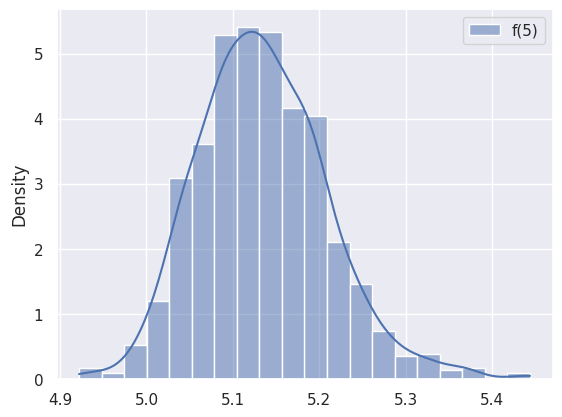

In [ ]:
NN_test(1, 5,10,0)